# MIL from Basics

The goal of this notebook is to build up increasingly complex MIL models and compare their performance to each-other.

## Pre-amble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import json
import os
import pandas as pd
import seaborn as sns
import glob
from natsort import natsorted
from scipy import stats
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import roc_auc_score, roc_curve
sns.set(style="whitegrid")

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
def process_folds(folds, aggregation_function, make_curve = False):
    aucs = []
    for fold in folds:
        labels = []
        confs = []
        for patient, data in fold.items():
            pred_key = 'predictions'
            label_key = 'label'
            if pred_key not in data:
                pred_key = 'val_predictions'
                label_key = 'val_label'
            if len(data[pred_key]) > 1:
                labels.append(data[label_key])
                confs.append(aggregation_function(data[pred_key]))
            else:
                continue
        auc = roc_auc_score(labels, confs)
        aucs.append(auc)
    return np.mean(aucs), np.std(aucs)

In [4]:
def predict_folds(folds, prediction_function, return_preds=False):
    accs = []
    if return_preds:
        predictions = {}
    for fold in folds:
        labels = []
        confs = []
        for patient, data in fold.items():
            pred_key = 'predictions'
            label_key = 'label'
            if pred_key not in data:
                pred_key = 'val_predictions'
                label_key = 'val_label'
            if len(data[pred_key]) > 1:
                labels.append(data[label_key])
                confs.append(prediction_function(data[pred_key]))
            else:
                continue
            if return_preds:
                if patient not in predictions:
                    predictions[patient] = prediction_function(data[pred_key])
        acc = np.mean(np.array(labels) == np.array(confs))
        accs.append(acc)
    if return_preds:
        return np.mean(accs), np.std(accs), predictions
    else:
        return np.mean(accs), np.std(accs)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Part 1 -- Score Only

In the following sections we will use MIL techniques on the scores only. Here a score is the output of the model for each cell, after the softmax operation has been applied.

## Data Loading

- `folds` are the test output data for each cell (can't use for training)
- `val_folds` are the valdiation output data for each cell (can use for training)

In [6]:
result_files = sorted(glob.glob('/home/colin/results_cov/cell_level/*.json'), key=lambda x: x[-6])
result_files_control = [r for r in result_files if 'control' in r]
result_files = [r for r in result_files if 'control' not in r]
all_patients = {}
folds = []
c_folds = []
mega_fold = {}
control_fold = {}
val_folds = []
fold_numbers = []
control_numbers = []
for result_file in sorted(result_files_control, key=lambda x: int(x[-6 - len('control_')])):
    with open(result_file) as fp:
        all_data = json.load(fp)
        fn = int(result_file[-6 - len('control_')])
        test_fold = {patient: data for patient, data in all_data.items() if 'controlpredictions' in data}
        for patient, data in test_fold.items():
            if patient in control_fold:
                control_fold[patient]['controlpredictions'] += data['controlpredictions']
            else:
                control_fold[patient] = data
        if fn in control_numbers:
            for patient, data in test_fold.items():
                c_folds[-1][patient]['controlpredictions'] += data['controlpredictions']
        else:
            c_folds.append(test_fold)
        control_numbers.append(fn)         

for result_file in sorted(result_files, key=lambda x: int(x[-6])):
    with open(result_file) as fp:
        fn = int(result_file[-6])
        all_data = json.load(fp)        
        test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
        val_fold = {patient: data for patient, data in all_data.items() if 'val_predictions' in data}
        if fn in fold_numbers:
            for patient, data in test_fold.items():
                folds[-1][patient]['predictions'] += data['predictions']
        else:
            folds.append(test_fold)
        fold_numbers.append(fn)         
        val_folds.append(val_fold)
        for patient, data in test_fold.items():
            if patient in mega_fold:
                mega_fold[patient]['predictions'] += data['predictions']
            else:
                mega_fold[patient] = data

In [10]:
result_files

['/home/colin/results_cov/cell_level/covid_class_3fdw8njf_fold_0.json',
 '/home/colin/results_cov/cell_level/covid_class_1abip6we_fold_0.json',
 '/home/colin/results_cov/cell_level/covid_class_3au2k57i_fold_1.json',
 '/home/colin/results_cov/cell_level/covid_class_1l33ib88_fold_1.json',
 '/home/colin/results_cov/cell_level/covid_class_1d3hpvs0_fold_2.json',
 '/home/colin/results_cov/cell_level/covid_class_1ngmy2jz_fold_2.json',
 '/home/colin/results_cov/cell_level/covid_class_z6u8j84u_fold_3.json',
 '/home/colin/results_cov/cell_level/covid_class_jaqln5pf_fold_3.json',
 '/home/colin/results_cov/cell_level/covid_class_171f08s0_fold_4.json',
 '/home/colin/results_cov/cell_level/covid_class_jup6btte_fold_4.json',
 '/home/colin/results_cov/cell_level/covid_class_1dbrkt2i_fold_5.json',
 '/home/colin/results_cov/cell_level/covid_class_2qyssv3y_fold_5.json']

## Data Visualization

In [7]:
sample_fold = mega_fold
patient_ids = []
confs = []
labels = []
counter = 0
pos_color = 'tab:blue'
net_color = 'tab:brown'
neg_color = 'tab:red'
for patient_id, data in sample_fold.items():
    if len(data['predictions']) > 5:
        patient_ids += [patient_id]*len(data['predictions'])
        infer = hist_pred(data['predictions'])
        if infer == data['label']:
            if data['label'] == 0:
                stat = 'True Negative'
            else:
                stat = 'True Positive'
        else:
            if data['label'] == 0:
                stat = 'False Positive'
            else:
                stat = 'False Negative'
        labels += [stat]*len(data['predictions'])
        confs += data['predictions']
        counter += 1
    if counter > 6:
        pd_data = pd.DataFrame(data ={
            'Patient ID': patient_ids,
            'Inference': labels,
            'Prediction': np.array(confs)
        })
        plt.figure(figsize=(20,5))
        g = sns.violinplot(x='Patient ID', y='Prediction', hue='Inference', data=pd_data,
                      scale='width', cut=0, )

        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        patient_ids = []
        confs = []
        labels = []
        counter = 0
        break
if counter != 0:
    pd_data = pd.DataFrame(data ={
            'Patient ID': patient_ids,
            'Inference': labels,
            'Prediction': np.array(confs)
        })
    plt.figure(figsize=(20,5))
    g = sns.violinplot(x='Patient ID', y='Prediction', hue='Inference', data=pd_data,
                  scale='width', cut=0, )
    g.set_xticklabels(g.get_xticklabels(), rotation=30)

NameError: name 'hist_pred' is not defined

In [7]:
pd_data = pd.DataFrame(data ={
    'Patient ID': patient_ids,
    'Label': labels,
    'Prediction': np.array(confs)
})

[Text(0, 0, '10049315976'),
 Text(1, 0, '10049465324'),
 Text(2, 0, '10049466408'),
 Text(3, 0, '10049467293'),
 Text(4, 0, '10049468376'),
 Text(5, 0, '10049502154'),
 Text(6, 0, '10049502558')]

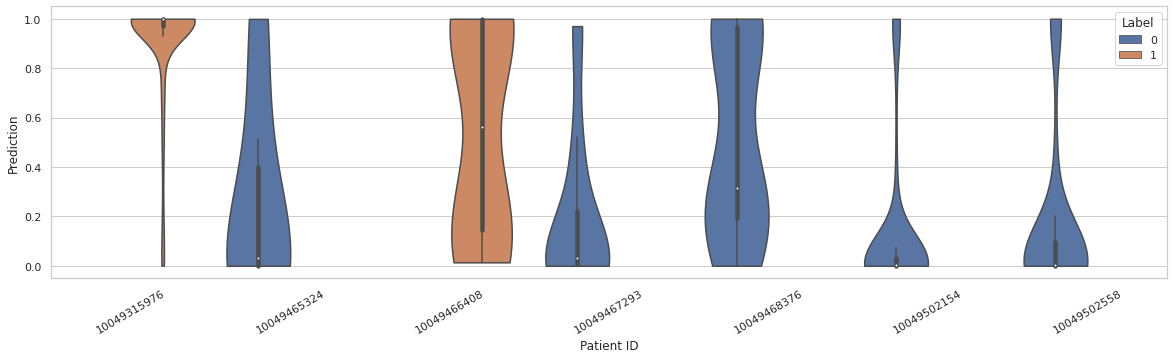

In [8]:
plt.figure(figsize=(20,5))
g = sns.violinplot(x='Patient ID', y='Prediction', hue='Label', data=pd_data,
              scale='width', cut=0, )
g.set_xticklabels(g.get_xticklabels(), rotation=30)


## Simple: Mean, Median, Mode

In [9]:
simple_aucs = {}

### Mean

Doesn't need training, assumption is that the "average" of all cell scores is the best overall score for that patient

In [10]:
avg_auc, std_auc = process_folds(folds, np.mean)
simple_aucs['mean'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

0.9289589715028314 0.05553662355458432


### Median
Doesn't need training, assumption is that the "median" of all the cell scores i the best overall score for that patient

In [13]:
avg_auc, std_auc = process_folds(folds, np.median)

print(avg_auc, std_auc)

0.9388726445743988 0.05333945073442513


In [12]:
avg_auc, std_auc = process_folds([mega_fold], np.median)
# simple_aucs['median'] = {
#     'average': avg_auc,
#     'std': std_auc
# }
print(avg_auc, std_auc)

0.936950146627566 0.0


### Histogram
Doesn't need training. A little harder to use as we have floating point values. So instead we use the biggest bin of a histogram

In [8]:
def histogram(data):
    amnts, bins = np.histogram(data,bins=[0, 0.5, 1])
    return amnts[-1]/(np.sum(amnts))

avg_auc, std_auc = process_folds(folds, histogram)

print(avg_auc, std_auc)

0.9366819827346142 0.05449415851648924


In [9]:
def histogram(data):
    amnts, bins = np.histogram(data,bins=[0, 0.5, 1])
    return amnts[-1]/(np.sum(amnts))

avg_auc, std_auc = process_folds(folds, histogram)
# # simple_aucs[f'histogram_{10}'] = {
# #     'average': avg_auc,
# #     'std': std_auc
# # }

print(avg_auc, std_auc)

0.9366819827346142 0.05449415851648924


In [115]:
(len(standard_tns) + len(standard_tps)) / (len(standard_fps) + len(standard_fns) + len(standard_tns) + len(standard_tps))

0.8504273504273504

In [116]:
(len(challenge_tns) + len(challenge_tps)) / (len(challenge_fps) + len(challenge_fns) + len(challenge_tns) + len(challenge_tps))

0.6842105263157895

In [112]:
all_v_data = []

for c in standard_fps:
    all_v_data.append(['Standard',  c, 'Positive', 'Negative'])

for c in standard_tps:
    all_v_data.append(['Standard',  c, 'Positive', 'Positive'])

for c in standard_fns:
    all_v_data.append(['Standard', c, 'Negative', 'Positive'])

    
for c in standard_tns:
    all_v_data.append(['Standard', c, 'Negative', 'Negative'])



all_c_data = all_v_data
for c in challenge_fps:
    all_c_data.append(['Challenge',  c, 'Positive', 'Negative'])
for c in challenge_tps:
    all_c_data.append(['Challenge',  c, 'Positive', 'Positive'])
for c in challenge_fns:
    all_c_data.append(['Challenge', c, 'Negative', 'Positive'])
for c in challenge_tns:
    all_c_data.append(['Challenge', c, 'Negative', 'Negative'])


In [113]:
pd_data = pd.DataFrame(all_v_data, columns=['Trial', 'Confidence', 'Predicted Condition', "True Condition"])
pdc_data = pd.DataFrame(all_c_data, columns=['Trial', 'Confidence', 'Predicted Condition', "True Condition"])

(0.0, 1.0)

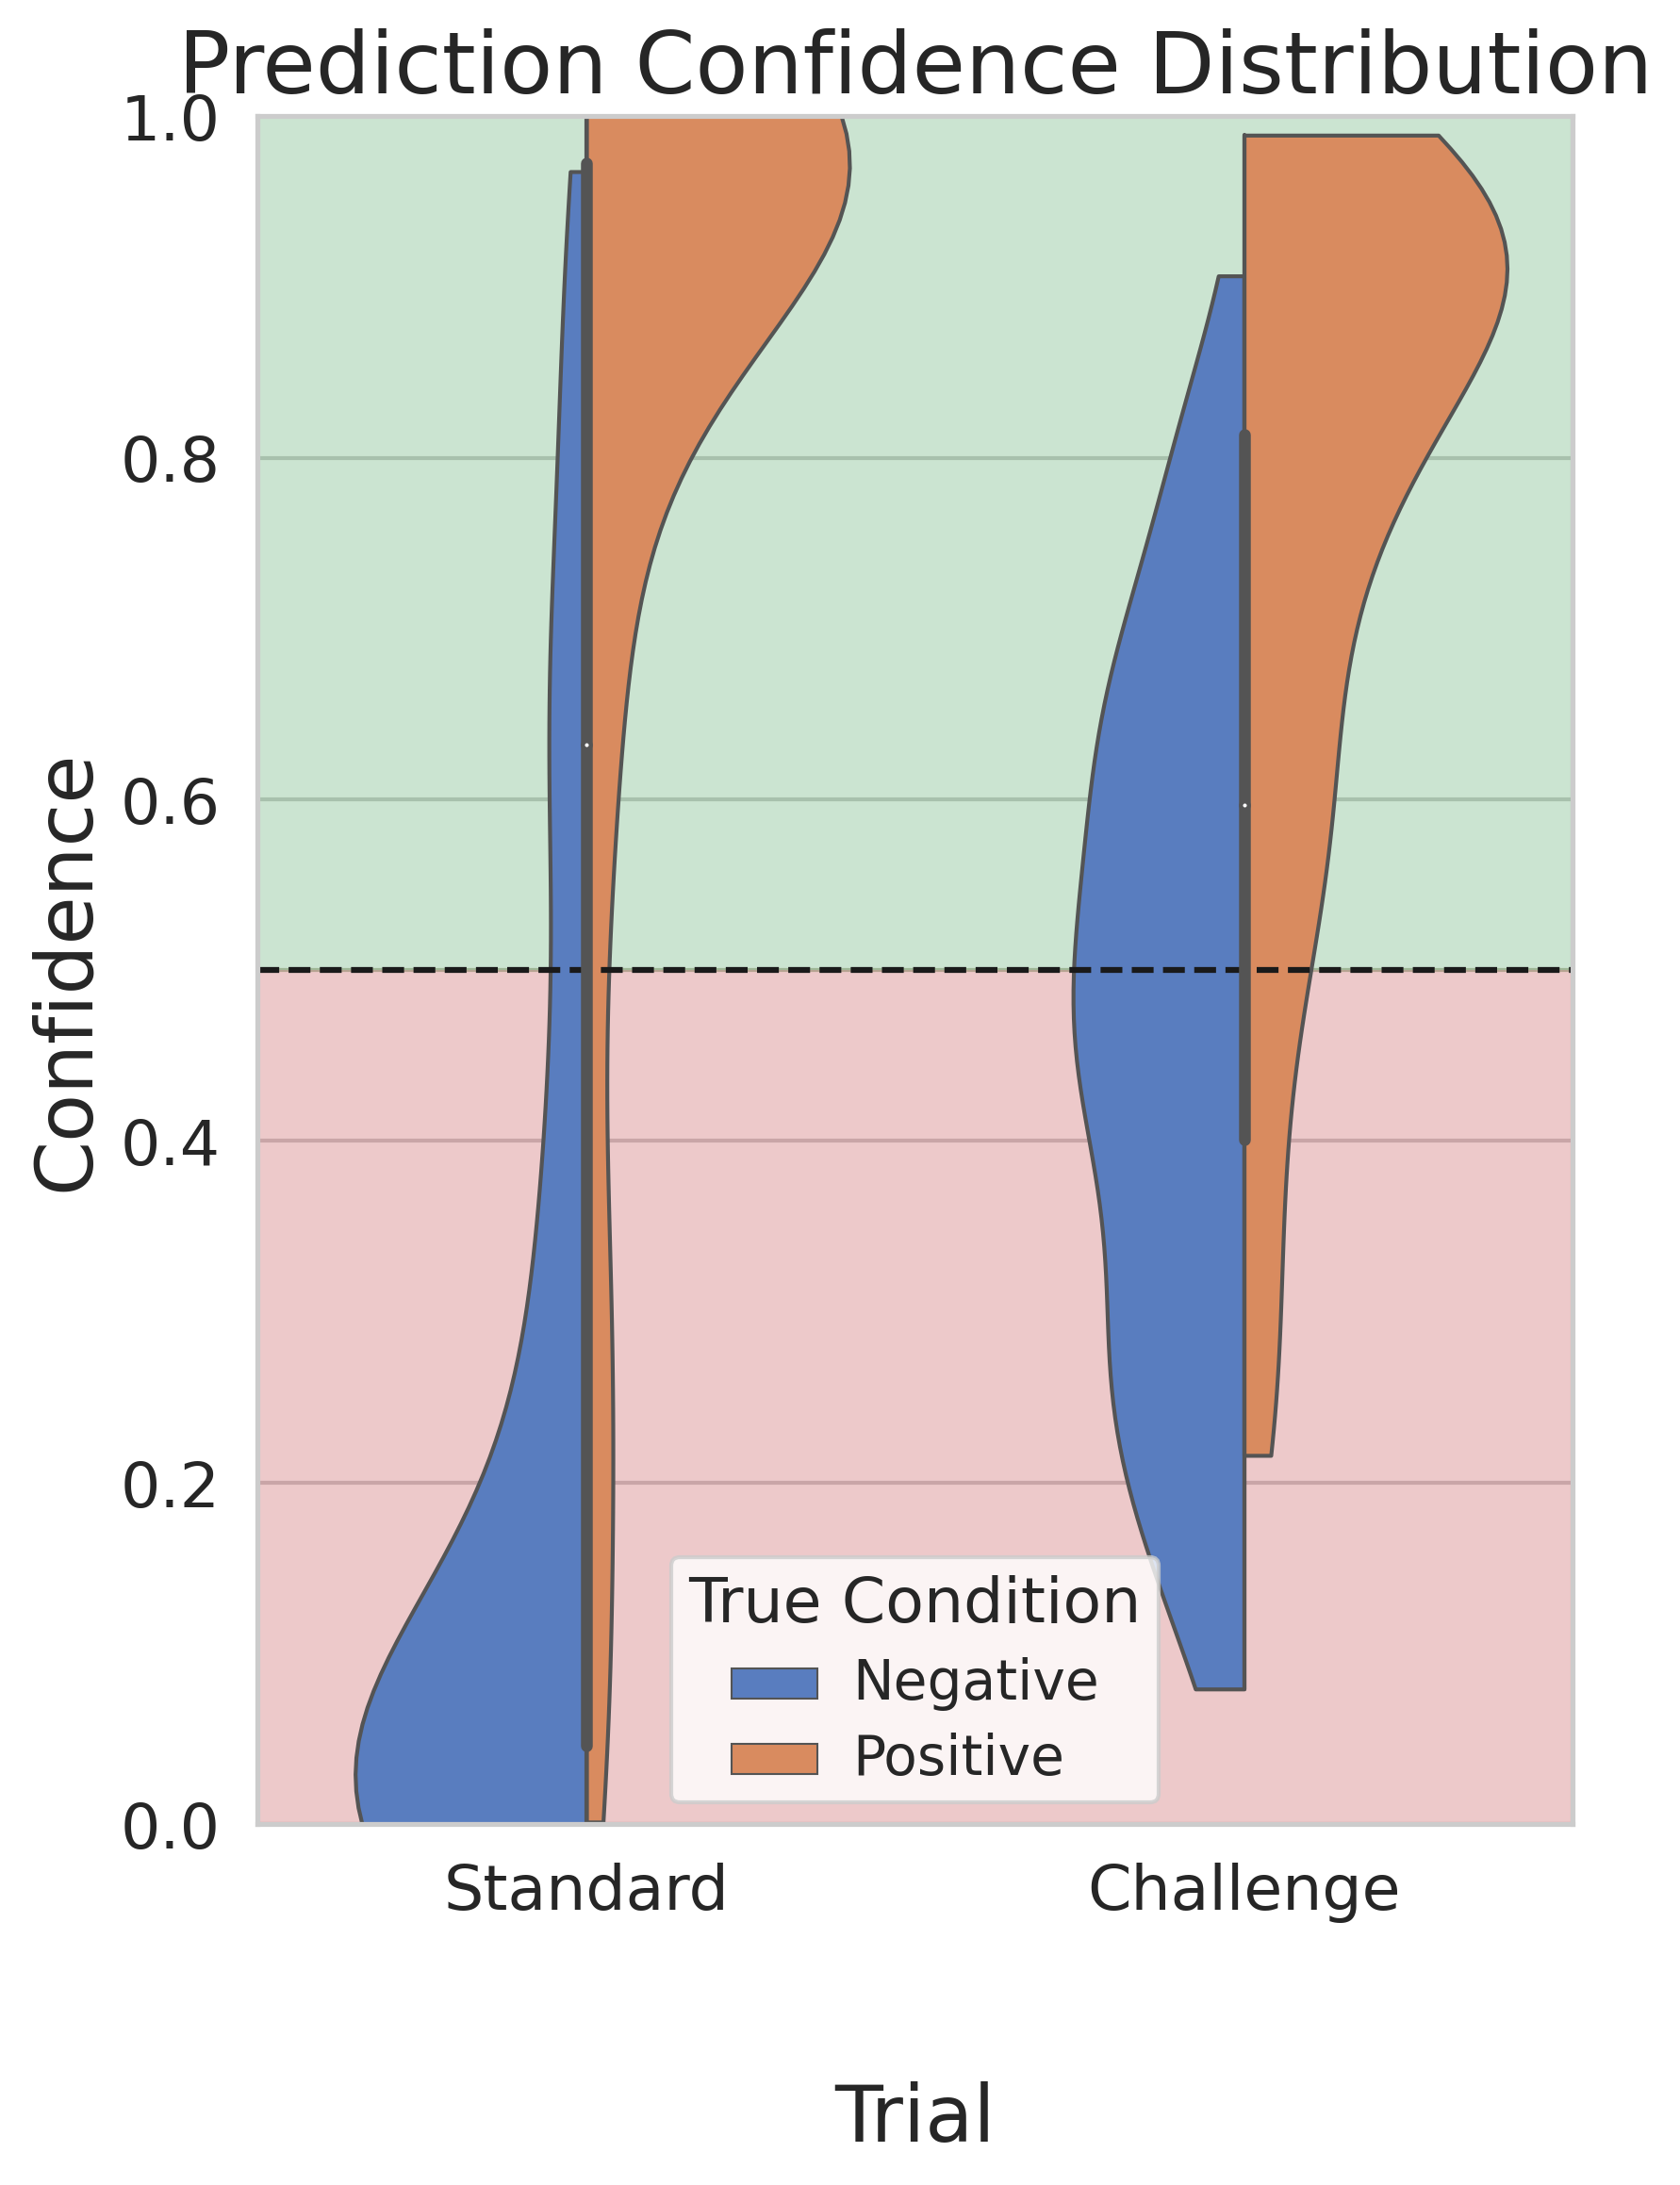

In [114]:
import pandas as pd
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 8))
start_x, end_x = -0.7, 1.5
axs.fill_between([start_x, end_x], 0, 0.5, color='r', alpha=0.3)
axs.fill_between([start_x, end_x], 0.5, 1., color='g', alpha=0.3)
sns.violinplot(x="Trial", y="Confidence", hue="True Condition",
                    data=pd_data, split=True,  palette="muted", linewidth=1, ax=axs, cut=0)
axs.set_title("Prediction Confidence Distribution", fontsize=22)
axs.tick_params(axis='both', which='major', labelsize=16) 
plt.setp(axs.get_legend().get_title(), fontsize='16')
plt.setp(axs.get_legend().get_texts(), fontsize='14')
# axs.yaxis.set_label_coords(-0.15, 1.1)
axs.xaxis.set_label_coords(0.5, -0.15)
axs.set_ylabel('Confidence',fontsize=20)
axs.set_xlabel('Trial',fontsize=20)
axs.hlines(0.5, -0.5, 1.5, color='k', linestyles='dashed')
axs.set_xlim(left=-0.5, right=1.5)
axs.set_ylim(top=1.0, bottom=0.0)


# sns.violinplot(x="Prediction", y="Confidence", hue="Condition",
#                     data=pd_data, split=False, cut=0)

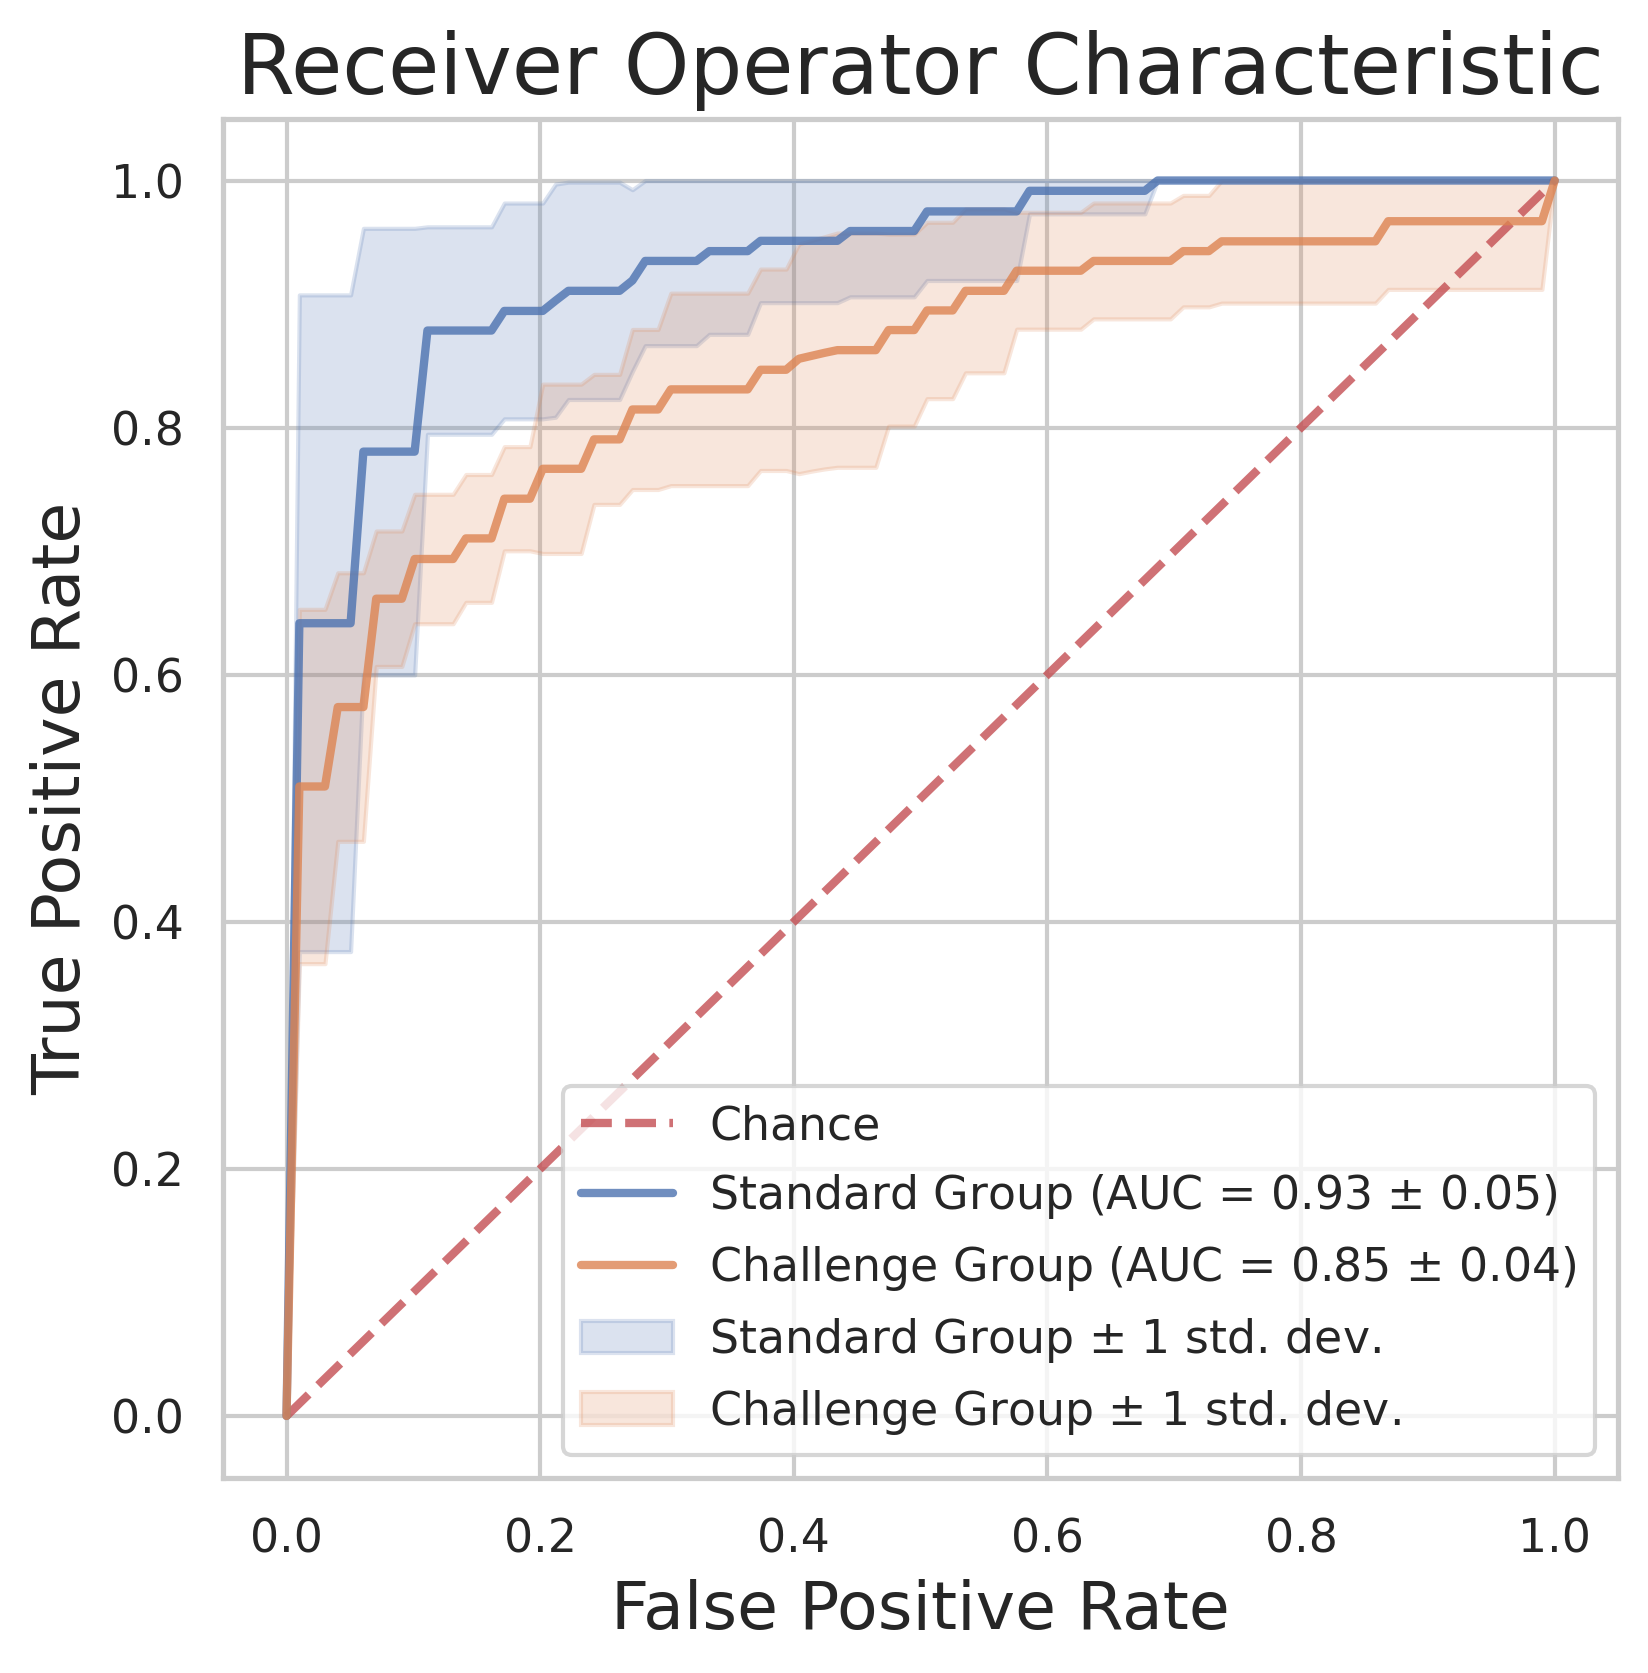

In [117]:
def pg(probs):
    a = 1
    probs = np.array(probs)
    logits = probs / (1 - probs + 0.000001)
    inner = logits ** (1/len(probs))
    prod = np.prod(inner)
    top = prod **a
    bottom = 1 + prod**a
    return top/bottom

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
# NORMAL
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

standard_fps = []
standard_tps = []
standard_fns = []
standard_tns = []

challenge_fps = []
challenge_tps = []
challenge_fns = []
challenge_tns = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for fold, c_fold in zip(folds, c_folds):
    labels = [data['label'] for data in fold.values()]
    confs = [histogram(data['predictions']) for data in fold.values()]
    standard_tps += [c for c, l in zip(confs, labels) if c > 0.5 and l == 1]
    standard_fps += [c for c, l in zip(confs, labels) if c > 0.5 and l == 0]
    standard_tns += [c for c, l in zip(confs, labels) if c <= 0.5 and l == 0]
    standard_fns += [c for c, l in zip(confs, labels) if c <= 0.5 and l == 1]
    auc = roc_auc_score(labels, confs)
    fpr, tpr, _ = roc_curve(labels, confs)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
mean_tpr = np.mean(tprs, axis=0)

mean_tpr[-1] = 1.0
mean_auc = auc_score(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
pl = ax.plot(mean_fpr, mean_tpr,
        label=r'Standard Group (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=pl[0].get_color(), alpha=.2,
                label=r'Standard Group $\pm$ 1 std. dev.')

# CHALLENGE
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for fold, c_fold in zip(folds, c_folds):
    labels = [data['label'] for data in fold.values()]
    confs = [histogram(data['predictions']) for data in fold.values()]
    labels_control = [data['controllabel'] for data in c_fold.values()]
    confs_control = [histogram(data['controlpredictions']) for data in c_fold.values()]
    for label, conf in zip(labels, confs):
        if label == 1:
            labels_control.append(label)
            confs_control.append(conf)
    
    challenge_tps += [c for c, l in zip(confs_control, labels_control) if c > 0.5 and l == 1]
    challenge_fps += [c for c, l in zip(confs_control, labels_control) if c > 0.5 and l == 0]
    challenge_tns += [c for c, l in zip(confs_control, labels_control) if c <= 0.5 and l == 0]
    challenge_fns += [c for c, l in zip(confs_control, labels_control) if c <= 0.5 and l == 1]
    auc = roc_auc_score(labels_control, confs_control)
    fpr, tpr, _ = roc_curve(labels_control, confs_control)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
mean_tpr = np.mean(tprs, axis=0)

mean_tpr[-1] = 1.0
mean_auc = auc_score(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
pl = ax.plot(mean_fpr, mean_tpr,
        label=r'Challenge Group (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=pl[0].get_color(), alpha=.2,
                label=r'Challenge Group $\pm$ 1 std. dev.')

ax.set_title("Receiver Operator Characteristic", fontsize=20)
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.legend()

In [133]:
mpl

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

In [87]:
labels = [data['label'] for data in mega_fold.values()]
confs = [pg(data['predictions']) for data in mega_fold.values()]
labels_control = [data['controllabel'] for data in control_fold.values()]
confs_control = [pg(data['controlpredictions']) for data in control_fold.values()]

amnt = len(labels_control)
counter = 0
indices = np.arange(0, len(labels))
np.random.seed(0)
np.random.shuffle(indices)
for ind in indices:
    label, conf = labels[ind], confs[ind]
    if label == 0:
        continue
    labels_control.append(label)
    confs_control.append(conf)
    counter += 1
    if counter >= amnt:
        break


In [88]:
avg_auc = roc_auc_score(labels, confs)

In [89]:
control_auc = roc_auc_score(labels_control, confs_control)

Text(0.5, 1.0, 'Receiver Operator Characteristic')

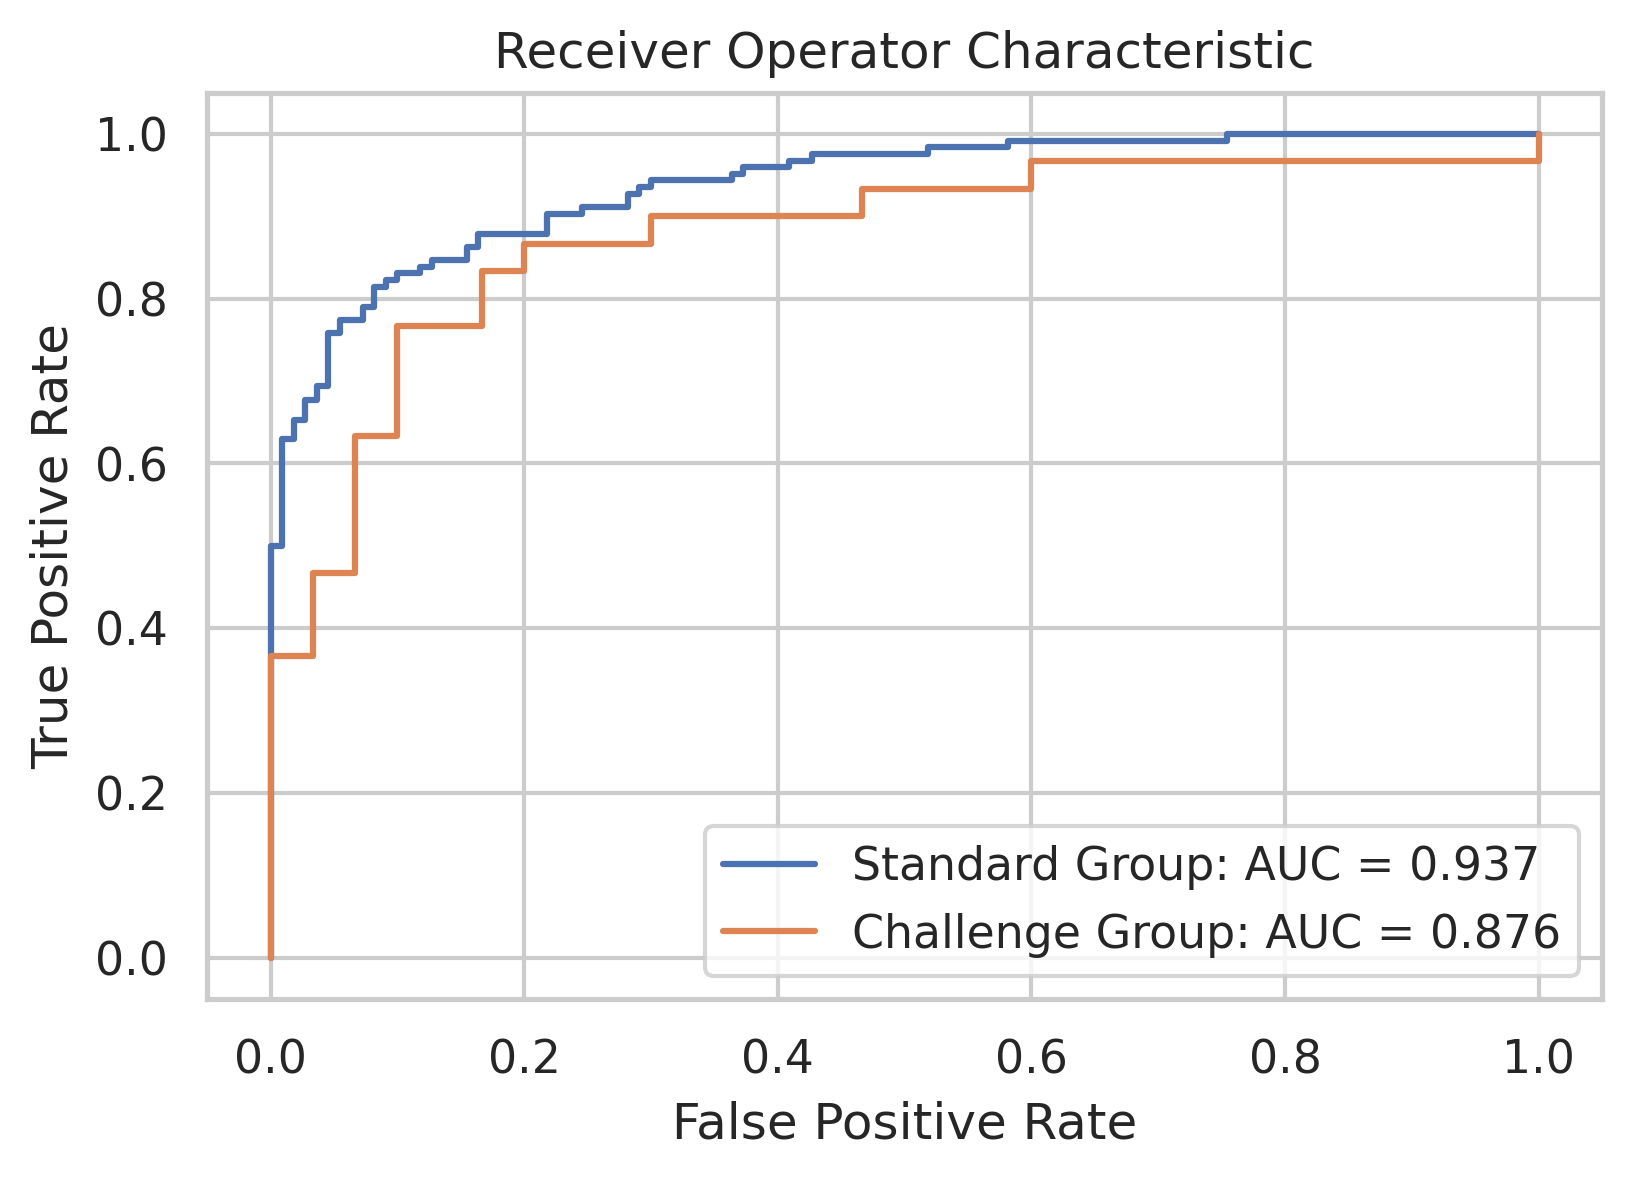

In [90]:
fpr, tpr, _ = roc_curve(labels, confs)
fpr_c, tpr_c, _ = roc_curve(labels_control, confs_control)
plt.plot(fpr, tpr, label=f'Standard Group: AUC = {avg_auc:.3f}')
plt.plot(fpr_c, tpr_c, label=f'Challenge Group: AUC = {control_auc:.3f}')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operator Characteristic")

## Dead Zone Optimization + Accuracy

For the histogram method, we also want to know when calculating accuracy, what the ideal dead zone is

In [7]:
# accuracy
def hist_pred(data, thresh=0.5):
    amnts, bins = np.histogram(data,bins=[0, thresh, 1])
    return int(amnts[0] < amnts[-1])
a,b,c = predict_folds([mega_fold], hist_pred, True)

In [18]:
a

0.8547008547008547

In [105]:
c['10051880000']

1

In [115]:
target_ids = [
"10049462978",
"10049403826",
"10049501529",
"10049489758",
"10049350365",
"10049490553",
"10049829656",
"10049315976",
"10050813540",
"10051257574",
"10050716522",
"10051871432",
"10051875445",
"10051879481",
"10049478075",
"10049389176",
"10050708114",
"10049418772",
"10049501646"
]

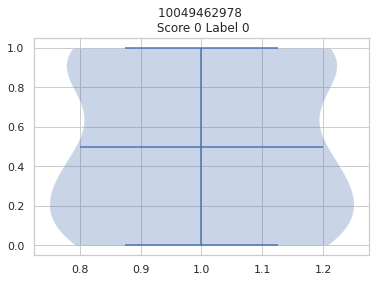

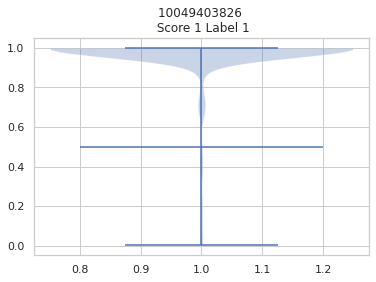

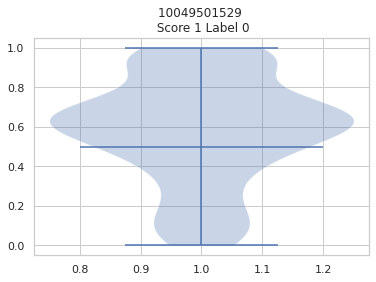

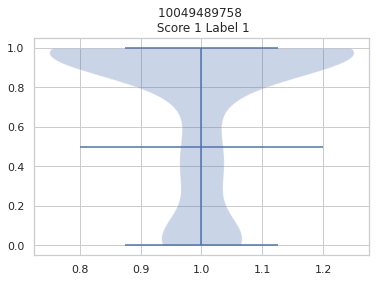

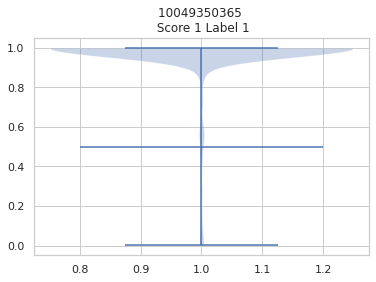

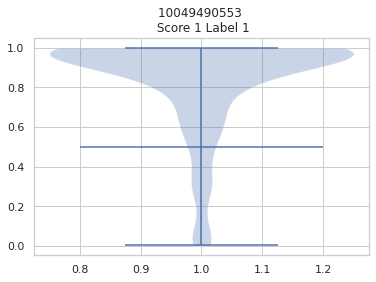

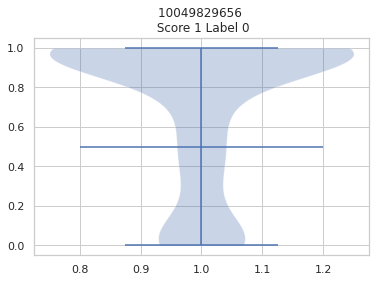

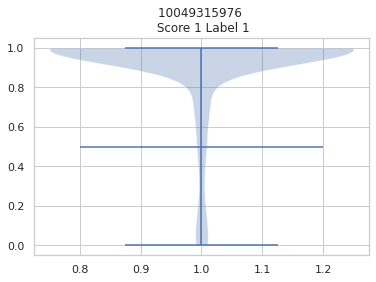

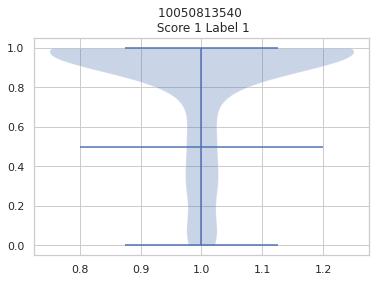

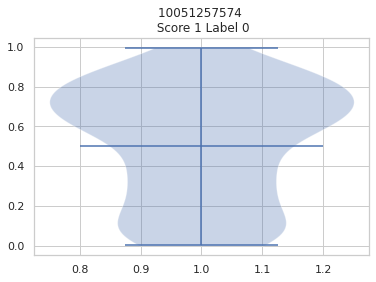

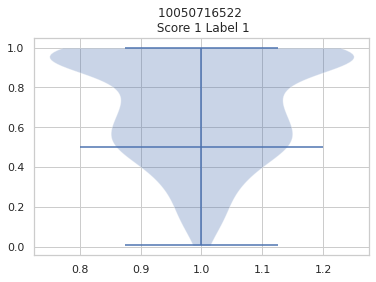

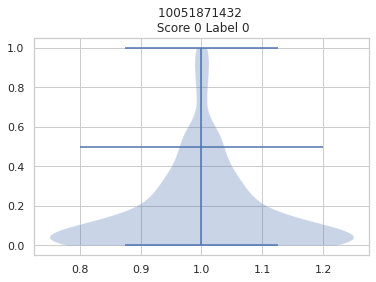

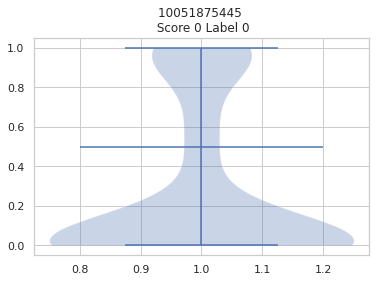

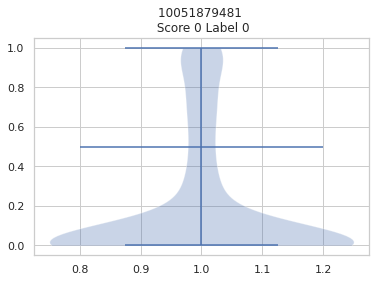

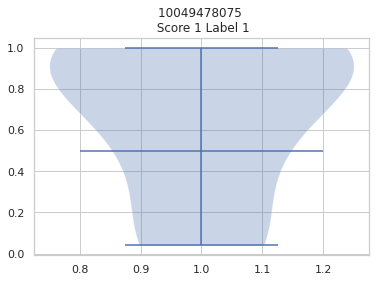

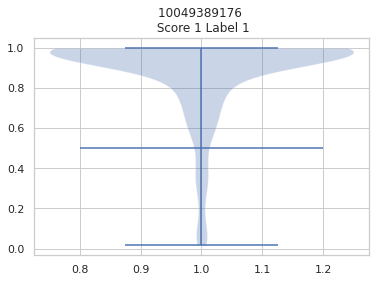

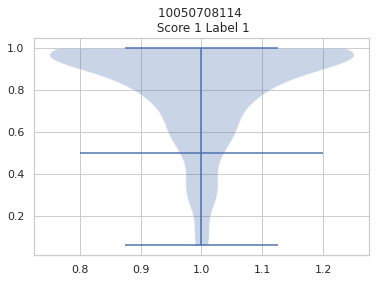

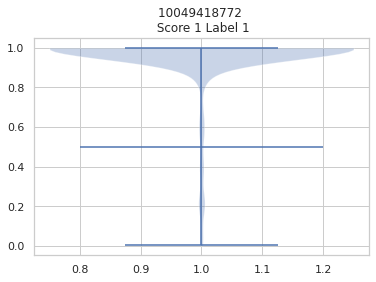

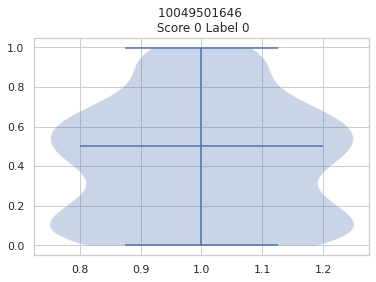

In [116]:
for target_id in target_ids:
    target_fold = None
    confs = []
    for fold in folds[::-1]:
        for patient in fold.keys():
            if target_id == patient:
                target_fold = fold
                confs += target_fold[target_id]['predictions']
                break
    plt.figure()
    threshold = 0.5
    score = hist_pred(confs, threshold)
    plt.violinplot(confs)
    plt.hlines(threshold, 0.8, 1.2)
    plt.title(f"{target_id} \n Score {score} Label {target_fold[target_id]['label']}")        

Text(0.5, 1.0, 'Score 1')

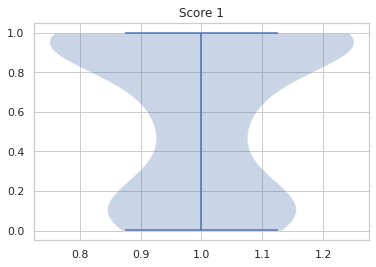

In [90]:
a, b, c = predict_folds(folds, hist_pred, True)

KeyError: 10051879408

In [107]:
def find_threshold(folds, prediction_function):
    best_acc = 0
    best_thresh = 0
    for thresh in np.linspace(0.3, 0.7, 100):
        accs = []
        for patient, data in fold.items():
            pred_key = 'predictions'
            label_key = 'label'
            if pred_key not in data:
                pred_key = 'val_predictions'
                label_key = 'val_label'
            if len(data[pred_key]) > 1:
                pred = prediction_function(data[pred_key], thresh)
                accs.append(int(pred == data[label_key]))
            else:
                continue
        if np.mean(accs) > best_acc:
            best_thresh = thresh
            best_acc = np.mean(accs)
    return best_acc, best_thresh

(0.8461538461538461, 0.4939393939393939)

In [142]:
def optimize_deadzone(folds, aggregation_function):
    accs = []
    all_confs = []
    all_labels = []
    for fold in folds:
        labels = []
        confs = []
        for patient, data in fold.items():
            pred_key = 'predictions'
            label_key = 'label'
            if pred_key not in data:
                pred_key = 'val_predictions'
                label_key = 'val_label'
            if len(data[pred_key]) > 1:
                labels.append(data[label_key])
                confs.append(aggregation_function(data[pred_key]))
            else:
                continue
        all_confs += confs
        all_labels += labels
    best_score = 0
    best_lower = 0
    best_upper = 0
    preds = np.array(all_confs)
    labs = np.array(all_labels)
    step = 0.05
    for lower in np.arange(0.1, 0.9, step):
        for upper in np.arange(lower + step, 0.95, step):
            score = np.sum((labs[preds > upper]*2 -1))
            score -= np.sum(labs[preds < lower]*2 -1)
            if score > best_score:
                best_lower = lower
                best_upper = upper
                best_score = score
    return best_score, best_lower, best_upper

In [143]:
optimize_deadzone(folds, histogram)

(310, 0.5500000000000002, 0.6500000000000002)

In [133]:
best_score = 0
best_lower = 0
best_upper = 0
step = 0.05
for lower in np.arange(0.1, 0.9, step):
    for upper in np.arange(lower + step, 0.95, step):
        score = np.sum((labs[preds > upper]*2 -1))
        score -= np.sum(labs[preds < lower]*2 -1)
        if score > best_score:
            best_lower = lower
            best_upper = upper
        break
    break

In [135]:
np.sum((labs[preds > upper]*2 -1))

0.0

In [136]:
preds

array([], dtype=float64)

### Plotting

Text(0, 0.5, 'AUC-ROC')

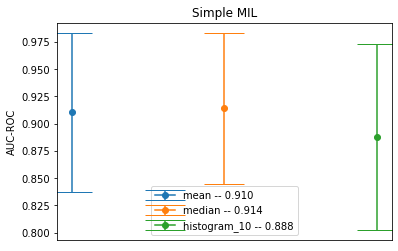

In [8]:
# lets plot what we have so far:
plt.figure()
plt.title("Simple MIL")
x_labels = list(simple_aucs.keys())
x_positions = np.arange(0, len(x_labels))
for x_label, x_position in zip(x_labels, x_positions):
    mean = simple_aucs[x_label]['average']
    plt.errorbar(x_position,mean , yerr=simple_aucs[x_label]['std'], label=x_label + f" -- {mean:.3f}", capsize=20, marker='o')
plt.legend()
plt.xticks([])
plt.ylabel("AUC-ROC")

## Non-Linear MIL Techniques
Now that we have the straight-forward techniques as a baseline, we can try some more interesting ones.


In [81]:
nonlinear_aucs = {}

### Noisy-OR

$ g(\{p_j\}) = 1 - \prod_j(1-p_j) $

In [82]:
def noisy_or(data):
    return 1 - np.product((1 - np.array(data)))

avg_auc, std_auc = process_folds(folds, noisy_or)
nonlinear_aucs['noisy-or'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

0.6841298848974288 0.10975573966754129


### ISR

$ g(\{p_j\}) = \frac{
\sum_j \frac{p_j}{1 - p_j}
}{
(1 + \sum_j \frac{p_j}{1 - p_j})
}$

In [68]:
process_folds(folds, pg)

(0.936229462545252, 0.054001081663449524)

In [83]:
def ISR(data):
    data = np.array(data)
    total = np.sum(data/(1-data + 0.00001))
    return total / (1 + total)

avg_auc, std_auc = process_folds(folds, ISR)
nonlinear_aucs['ISR'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

0.9023577462173952 0.06379412999258277


### Generalized Mean
$ g(\{p_j\}) = \left( \frac{1}{|j|} \sum_j p_j^r\right)^{\frac{1}{r}}$

In [84]:
def gen_mean(data, r=0.5):
    data = np.array(data)
    inner = np.mean(data ** r)
    return inner ** (1/r)

# find the best "r" value by brute force on the val set:
all_aucs = []
for model_ind in range(len(val_folds)):
    best_auc = 0
    best_r = 0
    for r in np.linspace(0.1, 5, 100):
        avg_auc, std_auc = process_folds(val_folds[model_ind:model_ind+1], lambda x: gen_mean(x, r))
        if avg_auc > best_auc:
            best_auc = avg_auc
            best_r = r
    single_auc = process_folds(folds[model_ind:model_ind+1], lambda x: gen_mean(x, best_r))[0]
    all_aucs.append(single_auc)
    print(best_r)
avg_auc = np.mean(all_aucs)
std_auc = np.std(all_aucs)
nonlinear_aucs[f'GM'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

4.208080808080808
0.198989898989899
1.4363636363636367
2.475757575757576
4.257575757575758
3.1191919191919197
1.1393939393939396
0.297979797979798
3.911111111111112
3.5151515151515156
0.1
0.1
0.908955258516662 0.07063951067530462


### LSE
$ g(\{p_j\}) = \frac{1}{r} log \left( \frac{1}{|j|} \sum_j e^{r p_j}\right)$

In [85]:
def lse(data, r):
    data = np.array(data)
    inner = np.mean(np.exp(r*data))
    return np.log(inner)/r

# find the best "r" value by brute force on the val set:
all_aucs = []
for model_ind in range(len(val_folds)):
    best_auc = 0
    best_r = 0
    for r in np.linspace(0.1, 5, 100):
        avg_auc, std_auc = process_folds(val_folds[model_ind:model_ind+1], lambda x: lse(x, r))
        if avg_auc > best_auc:
            best_auc = avg_auc
            best_r = r
    single_auc = process_folds(folds[model_ind:model_ind+1], lambda x: lse(x, best_r))[0]
    all_aucs.append(single_auc)
    print(best_r)
avg_auc = np.mean(all_aucs)
std_auc = np.std(all_aucs)
nonlinear_aucs[f'LSE_opt'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

4.604040404040404
0.1
0.693939393939394
1.8323232323232326
4.851515151515152
3.5151515151515156
0.396969696969697
1.1393939393939396
3.168686868686869
3.663636363636364
0.1
0.1
0.9104984683932053 0.07160194064578952


Text(0, 0.5, 'AUC-ROC')

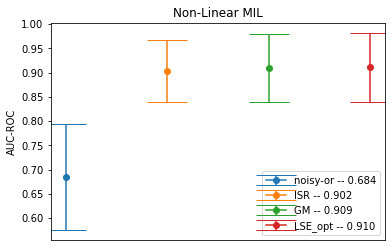

In [86]:
# lets plot what we have so far:
plt.figure()
plt.title("Non-Linear MIL")
x_labels = list(nonlinear_aucs.keys())
x_positions = np.arange(0, len(x_labels))
for x_label, x_position in zip(x_labels, x_positions):
    mean = nonlinear_aucs[x_label]['average']
    plt.errorbar(x_position,mean , yerr=nonlinear_aucs[x_label]['std'], label=x_label + f" -- {mean:.3f}", capsize=20, marker='o')
plt.legend()
plt.xticks([])
plt.ylabel("AUC-ROC")

## Learned Strategies

In [127]:
# we have one number, we could learn a weight + non-linearity + bias
def tanh_learned(data, scale=12, bias=12):
    data = np.array(data)
    return (np.exp(np.mean(data)*scale + bias))

In [128]:
avg_auc, std_auc = process_folds(folds, tanh_learned)
print(avg_auc)

0.9102768495312356


### DBScan


In [96]:
from sklearn.cluster import DBSCAN

def db_scanner(data):
    clustering = DBSCAN(eps=3, min_samples=2).fit(np.array(data).reshape(-1, 1))
    return np.mean(clustering.labels_)

avg_auc, std_auc = process_folds(folds, db_scanner)
cluster_aucs['dbscan'] = {
    'average': avg_auc,
    'std': std_auc
}
print(avg_auc, std_auc)

0.5 0.0


### Transformer

In [232]:
import torch
from torch import nn

class SimpleTransformer(nn.Module):
    
    def __init__(self):
        super(SimpleTransformer, self).__init__()
        self.pt_forward = nn.Linear(1, 4)
        self.model = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=4, nhead=2, dim_feedforward=16, dropout=0.0),num_layers=2)
        self.classification_vec = nn.Linear(1, 1)
        self.final_layer = nn.Linear(4, 1)
    
    def forward(self, x):
        vec = self.classification_vec(torch.ones(1).view(1, 1))
        data = torch.cat([x_data.view(1, -1), vec], dim=1).view(1,-1,1)
        extra = self.pt_forward(data.view(-1, 1)).view(1, -1, 4)
        out = self.model(extra)
        return torch.sigmoid(self.final_layer(out)[0,-1])
        
    

In [233]:
mm = SimpleTransformer()
mm(x_data).shape

torch.Size([1])

In [234]:
from tqdm.notebook import tqdm

In [235]:
optim = torch.optim.Adam(mm.parameters())

In [236]:
loss_fn = nn.BCELoss()
for e in range(10):
    for val_fold in tqdm(val_folds):
        accs = []
        for patient, data in val_fold.items():
            x_data = torch.tensor(data['val_predictions'])
            y_data = torch.tensor(data['val_label'])
            out = mm(x_data)
            accs.append((torch.round(out) == y_data).item())
            loss = loss_fn(mm(x_data), y_data.float())
            loss.backward()
            optim.step()
        print(loss.item())
        print("Acc: ", np.mean(accs))

/home/colin/anaconda3/envs/covid/lib/python3.8/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


0.7768231630325317
Acc:  0.5128205128205128
0.5316540598869324
Acc:  0.48717948717948717
0.5834574699401855
Acc:  0.48717948717948717
0.6903363466262817
Acc:  0.48717948717948717
0.8027445077896118
Acc:  0.5128205128205128
0.8653637170791626
Acc:  0.5128205128205128
0.8607265949249268
Acc:  0.5128205128205128
0.7945421934127808
Acc:  0.5128205128205128
0.7153934836387634
Acc:  0.5128205128205128
0.6632694602012634
Acc:  0.5128205128205128
0.6313213109970093
Acc:  0.48717948717948717
0.627426028251648
Acc:  0.48717948717948717



0.659682035446167
Acc:  0.48717948717948717
0.7252233624458313
Acc:  0.4358974358974359
0.7975595593452454
Acc:  0.5128205128205128
0.8467220067977905
Acc:  0.5128205128205128
0.8687049746513367
Acc:  0.5128205128205128
0.8154523372650146
Acc:  0.5128205128205128
0.7241455316543579
Acc:  0.5128205128205128
0.6317012906074524
Acc:  0.6410256410256411
0.5688855648040771
Acc:  0.48717948717948717
0.5850915312767029
Acc:  0.48717948717948717
0.6656467318534851
Acc:  0.48717948717948717
0.8115312457084656
Acc:  0.5641025641025641



0.9576353430747986
Acc:  0.5128205128205128
0.9203307628631592
Acc:  0.5128205128205128
0.6728339791297913
Acc:  0.6153846153846154
0.47852468490600586
Acc:  0.48717948717948717
0.4900880753993988
Acc:  0.48717948717948717
0.7133839130401611
Acc:  0.41025641025641024
1.0766452550888062
Acc:  0.5128205128205128
1.216780185699463
Acc:  0.5128205128205128
0.8966879844665527
Acc:  0.5128205128205128
0.5424107313156128
Acc:  0.6153846153846154
0.35611218214035034
Acc:  0.48717948717948717
0.33122554421424866
Acc:  0.48717948717948717



0.44801369309425354
Acc:  0.48717948717948717
0.678532600402832
Acc:  0.48717948717948717
0.9471071362495422
Acc:  0.5128205128205128
1.1561261415481567
Acc:  0.5128205128205128
1.2307016849517822
Acc:  0.5128205128205128
1.1097633838653564
Acc:  0.5128205128205128
0.8883557319641113
Acc:  0.5128205128205128
0.6774061322212219
Acc:  0.6153846153846154
0.5214192271232605
Acc:  0.48717948717948717
0.4253011643886566
Acc:  0.48717948717948717
0.3748246431350708
Acc:  0.48717948717948717
0.37298524379730225
Acc:  0.48717948717948717



0.4319298565387726
Acc:  0.48717948717948717
0.564433753490448
Acc:  0.48717948717948717
0.7693101167678833
Acc:  0.46153846153846156
1.0164592266082764
Acc:  0.5128205128205128
1.2439604997634888
Acc:  0.5128205128205128
1.317305326461792
Acc:  0.5128205128205128
1.1857573986053467
Acc:  0.5128205128205128
0.9270516633987427
Acc:  0.5128205128205128
0.6773169636726379
Acc:  0.5897435897435898
0.5049217939376831
Acc:  0.48717948717948717
0.40106067061424255
Acc:  0.48717948717948717
0.3611396849155426
Acc:  0.48717948717948717



0.38250550627708435
Acc:  0.48717948717948717
0.45970621705055237
Acc:  0.48717948717948717
0.5798428654670715
Acc:  0.48717948717948717
0.727120578289032
Acc:  0.41025641025641024
0.8874222636222839
Acc:  0.5128205128205128
1.0357391834259033
Acc:  0.5128205128205128
1.1547125577926636
Acc:  0.5128205128205128
1.2237499952316284
Acc:  0.5128205128205128
1.2264732122421265
Acc:  0.5128205128205128
1.1667382717132568
Acc:  0.5128205128205128
1.0529696941375732
Acc:  0.5128205128205128
0.915864109992981
Acc:  0.5128205128205128



0.7808594107627869
Acc:  0.5128205128205128
0.6593672633171082
Acc:  0.5641025641025641
0.5567373633384705
Acc:  0.48717948717948717
0.47999081015586853
Acc:  0.48717948717948717
0.4386385381221771
Acc:  0.48717948717948717
0.4334253668785095
Acc:  0.48717948717948717
0.47269296646118164
Acc:  0.48717948717948717
0.5622233748435974
Acc:  0.48717948717948717
0.7017784714698792
Acc:  0.41025641025641024
0.885658323764801
Acc:  0.5128205128205128
1.0704319477081299
Acc:  0.5128205128205128
1.213749885559082
Acc:  0.5128205128205128



1.2723263502120972
Acc:  0.5128205128205128
1.2018404006958008
Acc:  0.5128205128205128
0.9959953427314758
Acc:  0.5128205128205128
0.7303835153579712
Acc:  0.5128205128205128
0.5127691626548767
Acc:  0.5128205128205128
0.37762144207954407
Acc:  0.48717948717948717
0.3333226442337036
Acc:  0.48717948717948717
0.37695541977882385
Acc:  0.48717948717948717
0.5226808190345764
Acc:  0.48717948717948717
0.7900469303131104
Acc:  0.358974358974359
1.1032243967056274
Acc:  0.5128205128205128
1.3464136123657227
Acc:  0.5128205128205128



1.418094515800476
Acc:  0.5128205128205128
1.2674850225448608
Acc:  0.5128205128205128
0.9536120891571045
Acc:  0.5128205128205128
0.6363986134529114
Acc:  0.6153846153846154
0.4282011091709137
Acc:  0.48717948717948717
0.3216297924518585
Acc:  0.48717948717948717
0.295358270406723
Acc:  0.48717948717948717
0.3343600630760193
Acc:  0.48717948717948717
0.43603312969207764
Acc:  0.48717948717948717
0.6022323369979858
Acc:  0.48717948717948717
0.8047233819961548
Acc:  0.5128205128205128
1.009913682937622
Acc:  0.5128205128205128



1.1761971712112427
Acc:  0.5128205128205128
1.253501534461975
Acc:  0.5128205128205128
1.2086575031280518
Acc:  0.5128205128205128
1.0615211725234985
Acc:  0.5128205128205128
0.8738036751747131
Acc:  0.5128205128205128
0.6872451901435852
Acc:  0.5641025641025641
0.536632776260376
Acc:  0.48717948717948717
0.42952975630760193
Acc:  0.48717948717948717
0.3625619411468506
Acc:  0.48717948717948717
0.33442020416259766
Acc:  0.48717948717948717
0.33842870593070984
Acc:  0.48717948717948717
0.37684550881385803
Acc:  0.48717948717948717



0.48717948717948717

In [203]:
accs

[tensor([[False]]),
 tensor([[False]]),
 tensor([[False]]),
 tensor([[True]]),
 tensor([[True]]),
 tensor([[False]]),
 tensor([[True]]),
 tensor([[True]]),
 tensor([[True]]),
 tensor([[True]]),
 tensor([[False]]),
 tensor([[False]])]

In [ ]:
mm(fol)

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward>)

In [173]:
y_data

tensor(1)

In [171]:
torch.tensor(data['val_predictions']).shape

torch.Size([148])

In [165]:
mm(x_data)

tensor([[8.3396e-07]], grad_fn=<SelectBackward>)

In [153]:
torch.cat([x_data.float().view(1, -1), torch.ones(1).view(1,1)], dim=1).shape

torch.Size([1, 151])

In [148]:
x_data = torch.zeros(150)